In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir("..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/datasource_hackathon


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

In [4]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [5]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

In [6]:
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.sort_values(["agency", "sku", "date"]).reset_index(drop=True)

In [7]:
df = data.groupby(["agency", "sku"], as_index=False)["date"].agg(["min", "max","nunique"])

In [8]:
df.head()

,agency,sku,min,max,nunique
0,Agency_01,SKU_01,2013-01-01,2017-12-01,60
1,Agency_01,SKU_02,2013-01-01,2017-12-01,60
2,Agency_01,SKU_03,2013-01-01,2017-12-01,60
3,Agency_01,SKU_04,2013-01-01,2017-12-01,60
4,Agency_01,SKU_05,2013-01-01,2017-12-01,60


In [9]:
# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

In [10]:
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx
0,Agency_01,SKU_01,80.676,2013-01-01,492612703,718394219,17.072,1141.500000,1033.432731,108.067269,153733,120207,0,0,1,0,0,0,0,0,0,0,0,0,9.467128,249,0
1,Agency_01,SKU_01,98.064,2013-02-01,431937346,753938444,19.984,1141.500000,1065.417195,76.082805,153733,120207,0,0,0,0,0,0,0,0,0,0,0,0,6.665160,249,1
2,Agency_01,SKU_01,133.704,2013-03-01,509281531,892192092,24.600,1179.345820,1101.133633,78.212187,153733,120207,1,1,0,0,0,0,0,0,0,0,0,1,6.631828,249,2
3,Agency_01,SKU_01,147.312,2013-04-01,532390389,838099501,27.532,1226.687500,1138.283357,88.404143,153733,120207,0,0,0,0,0,0,0,0,0,0,0,0,7.206737,249,3
4,Agency_01,SKU_01,175.608,2013-05-01,551755254,864420003,29.396,1230.331104,1148.969634,81.361470,153733,120207,0,0,0,0,1,0,0,0,0,0,0,0,6.612974,249,4


In [11]:
# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

In [12]:
# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")

In [13]:
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_01,SKU_01,80.676,2013-01-01,492612703,718394219,17.072,1141.500000,1033.432731,108.067269,153733,120207,-,-,new_year,-,-,-,-,-,-,-,-,-,9.467128,249,0,1,4.390441,2613.377501,74.82960
1,Agency_01,SKU_01,98.064,2013-02-01,431937346,753938444,19.984,1141.500000,1065.417195,76.082805,153733,120207,-,-,-,-,-,-,-,-,-,-,-,-,6.665160,249,1,2,4.585620,2916.978087,90.03670
2,Agency_01,SKU_01,133.704,2013-03-01,509281531,892192092,24.600,1179.345820,1101.133633,78.212187,153733,120207,easter_day,good_friday,-,-,-,-,-,-,-,-,-,music_fest,6.631828,249,2,3,4.895628,3215.061952,130.48715
3,Agency_01,SKU_01,147.312,2013-04-01,532390389,838099501,27.532,1226.687500,1138.283357,88.404143,153733,120207,-,-,-,-,-,-,-,-,-,-,-,-,7.206737,249,3,4,4.992553,3515.822697,130.24615
4,Agency_01,SKU_01,175.608,2013-05-01,551755254,864420003,29.396,1230.331104,1148.969634,81.361470,153733,120207,-,-,-,-,labor_day,-,-,-,-,-,-,-,6.612974,249,4,5,5.168254,3688.107793,159.05155


In [14]:
max_prediction_length = 6 # predict for 6 months
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length
print(training_cutoff)

53


In [15]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

## `TimeSeriesDataSet`

`TimeSeriesDataSet` is a PyTorch dataset designed to simplify the process of working with time series data for deep learning models. It provides various utilities such as scaling, encoding, normalizing, and converting time series data from pandas DataFrames to torch tensors, supporting both static and time-varying variables.

### Key Features:
- **Handling Static and Time-Varying Variables**: Supports categorical and continuous features, including known and unknown variables.
- **Scaling and Encoding**: Automatically scales and encodes variables based on provided configurations.
- **Efficient Conversion**: Converts pandas DataFrames to PyTorch tensors for fast model training.
- **Target Normalization**: Normalizes target variables with customizable normalization strategies.
- **Lags and Gaps**: Supports handling of lags and filling missing time steps.
- **Data Augmentation**: Offers downsampling options to augment data and improve model generalization.
- **Prediction Mode**: Special mode to generate inference, validation, and test datasets efficiently.

### Parameters:
- **data** (`pd.DataFrame`): DataFrame containing time series data.
- **time_idx** (`str`): Column indicating the time index for each series.
- **target** (`Union[str, List[str]]`): Column or list of columns specifying the target(s).
- **group_ids** (`List[str]`): Columns identifying individual time series.
- **weight** (`Optional[str]`): Optional column name for sample weights.
- **max_encoder_length** (`int`): Maximum length of the input sequence (encoder).
- **min_encoder_length** (`int`): Minimum length of the input sequence (defaults to `max_encoder_length`).
- **max_prediction_length** (`int`): Maximum length of the prediction sequence (decoder).
- **static_categoricals** (`List[str]`): Categorical variables that do not change over time.
- **static_reals** (`List[str]`): Continuous variables that do not change over time.
- **time_varying_known_categoricals** (`List[str]`): Categorical variables known in the future.
- **time_varying_known_reals** (`List[str]`): Continuous variables known in the future.
- **time_varying_unknown_categoricals** (`List[str]`): Categorical variables not known in the future.
- **time_varying_unknown_reals** (`List[str]`): Continuous variables not known in the future.
- **lags** (`Dict[str, List[int]]`): Specifies lagged variables to capture seasonality or trends.
- **add_relative_time_idx** (`bool`): Adds a relative time index as a feature (ranges from -encoder_length to prediction_length).
- **add_target_scales** (`bool`): Adds scales for target variables to static real features.
- **target_normalizer** (`Union[TorchNormalizer, NaNLabelEncoder, EncoderNormalizer, str, list, tuple]`): Normalizer for target variables.
- **categorical_encoders** (`Dict[str, NaNLabelEncoder]`): Encoders for categorical features.
- **scalers** (`Dict[str, Union[StandardScaler, RobustScaler, TorchNormalizer, EncoderNormalizer]]`): Scalers for continuous features.
- **randomize_length** (`Union[None, Tuple[float, float], bool]`): Option to randomize sequence lengths for data augmentation.
- **predict_mode** (`bool`): If set to `True`, the dataset is used for generating predictions.

### Usage:
This dataset is used with PyTorch-based models by converting time series data into batches using the `to_dataloader` method. It helps handle missing data, provide lagged features, and efficiently prepares data for model training.



In [16]:
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Baseline Prediction

In [17]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-09-17 15:26:42.724788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 15:26:42.724840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 15:26:42.725923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 15:26:42.732949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other opera

tensor(293.0088, device='cuda:0')

Train the Temporal Fusion Transformer

In [18]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="adamw",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 13.5k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.008317637711026716
Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/datasource_hackathon/.lr_find_9b8c01cc-c472-4046-8724-08ccb90f0656.ckpt
Restored all states from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/datasource_hackathon/.lr_find_9b8c01cc-c472-4046-8724-08ccb90f0656.ckpt


suggested learning rate: 0.008317637711026716


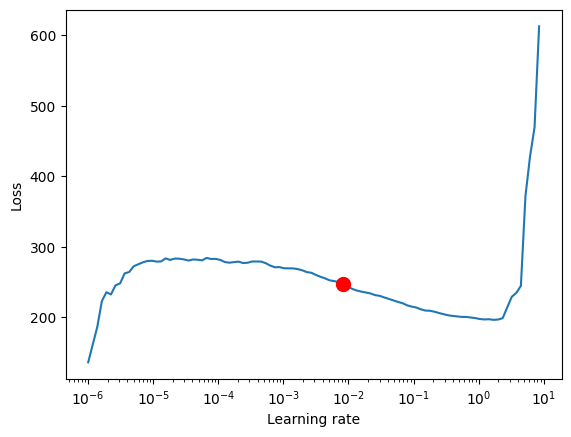

In [19]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [33]:
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [21]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

In [22]:
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger = None
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0083,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="adamw",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 29.4k


In [24]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [25]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [26]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(262.9344)

In [27]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


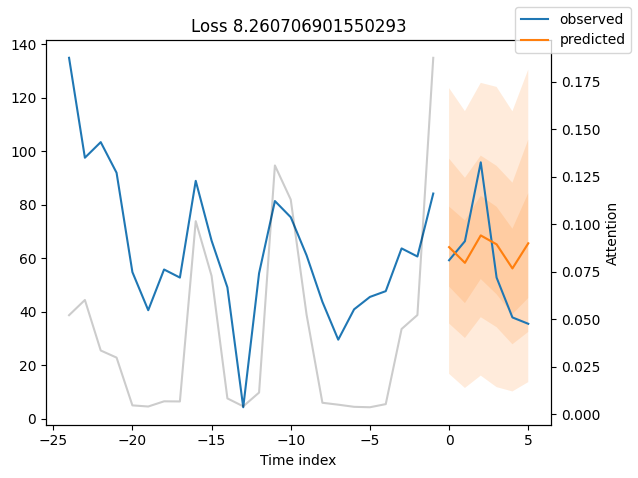

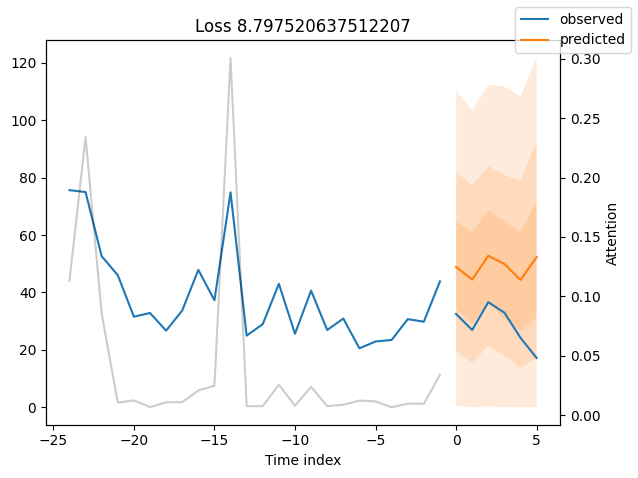

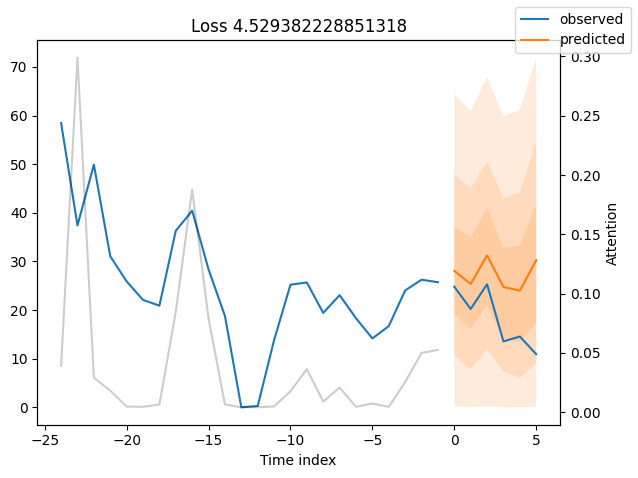

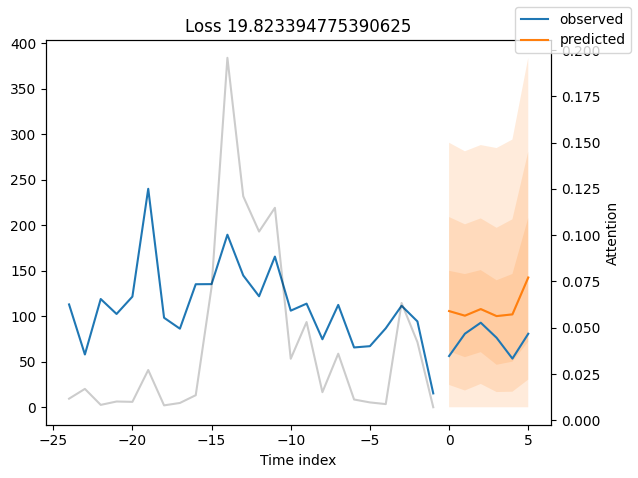

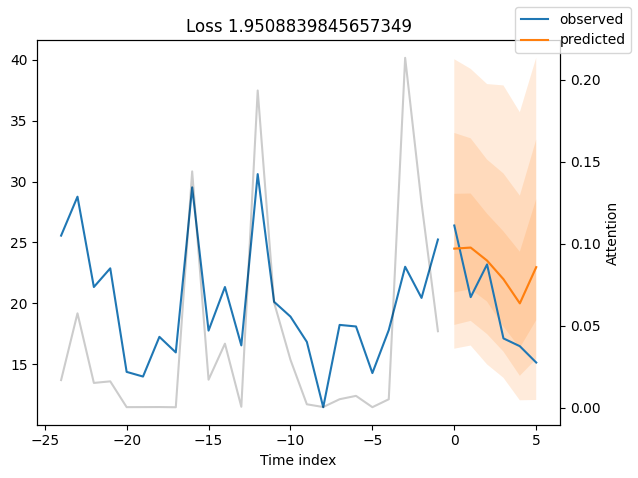

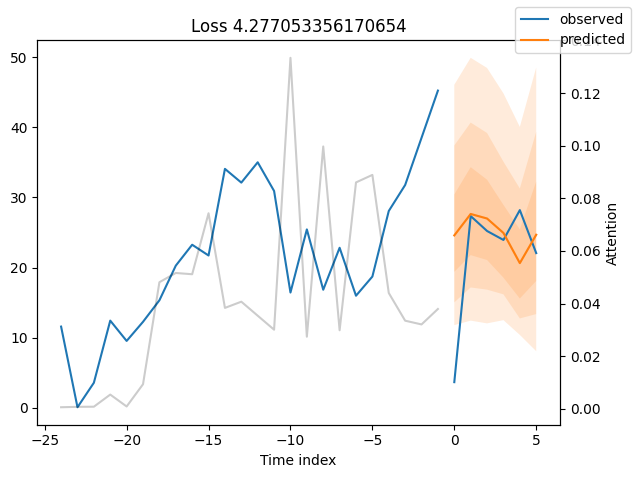

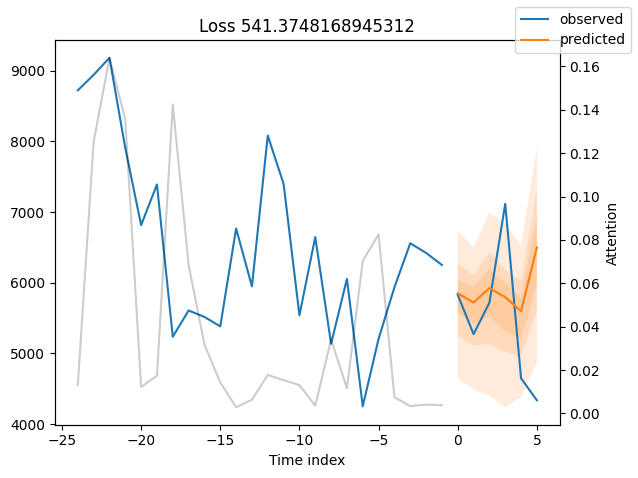

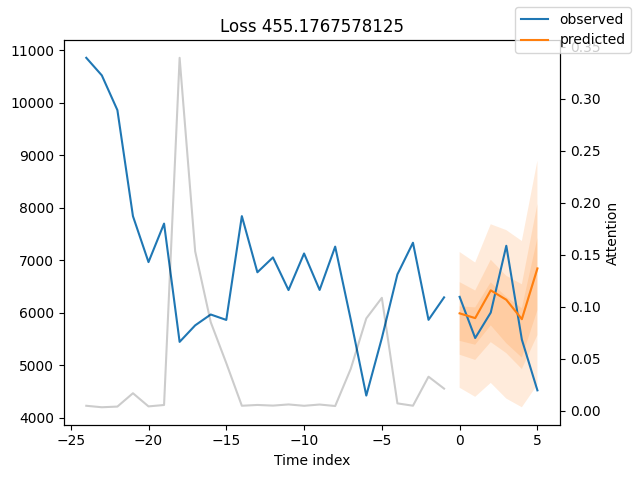

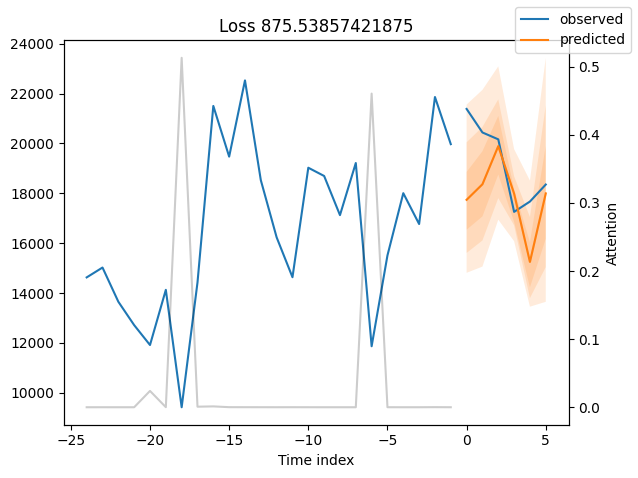

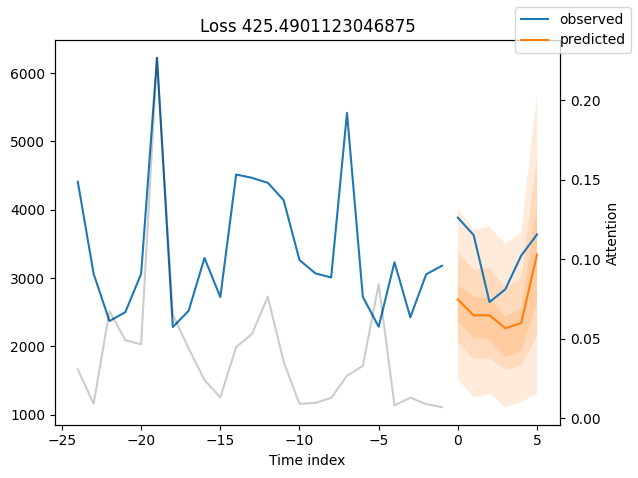

In [28]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'avg_population_2017': <Figure size 1000x500 with 2 Axes>,
 'avg_yearly_household_income_2017': <Figure size 1000x500 with 2 Axes>,
 'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'volume_center': <Figure size 1000x500 with 2 Axes>,
 'volume_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'price_regular': <Figure size 1000x500 with 2 Axes>,
 'discount_in_percent': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'volume': <Figure size 1000x500 with 2 Axes>,
 'log_volume': <Figure size 1000x500 with 2 Axes>,
 'industry_volume': <Figure size 1000x500 with 2 Axes>,
 'soda_volume': <Figure size 1000x500 with 2 Axes>,
 'avg_max_temp': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_agency': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_sku': <Figure size 1000x500 with 2 Axes>,
 'agency': <Figure size 1000x500 with 2 Axes>,
 'sku': <Figure size 1000x500 with 2 Axes>,
 'special_days'

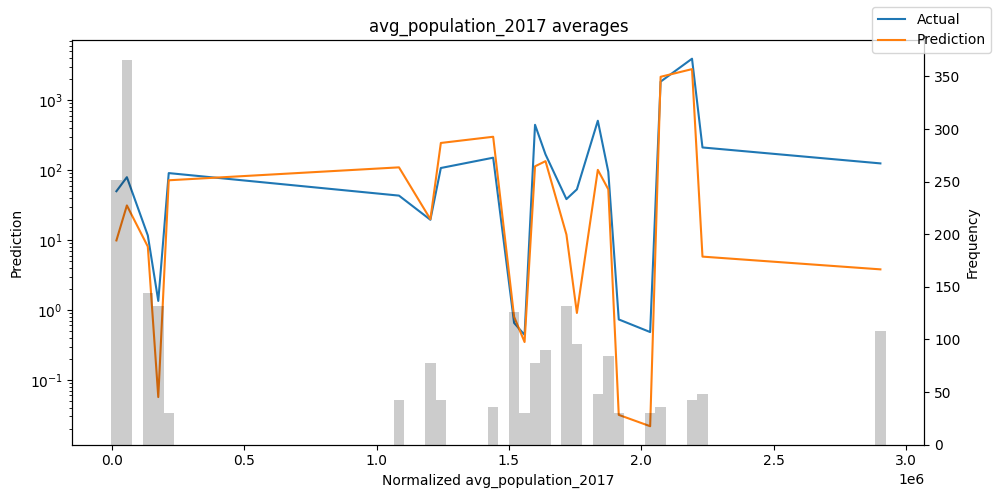

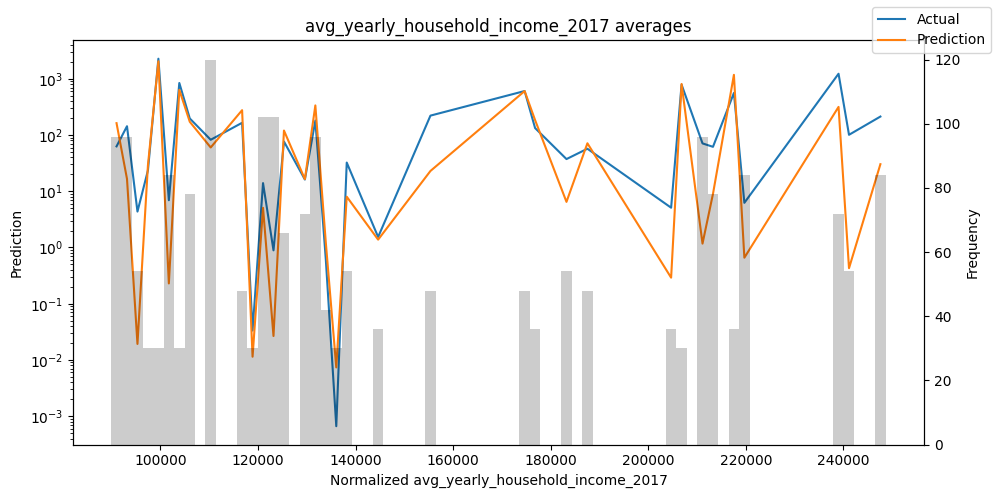

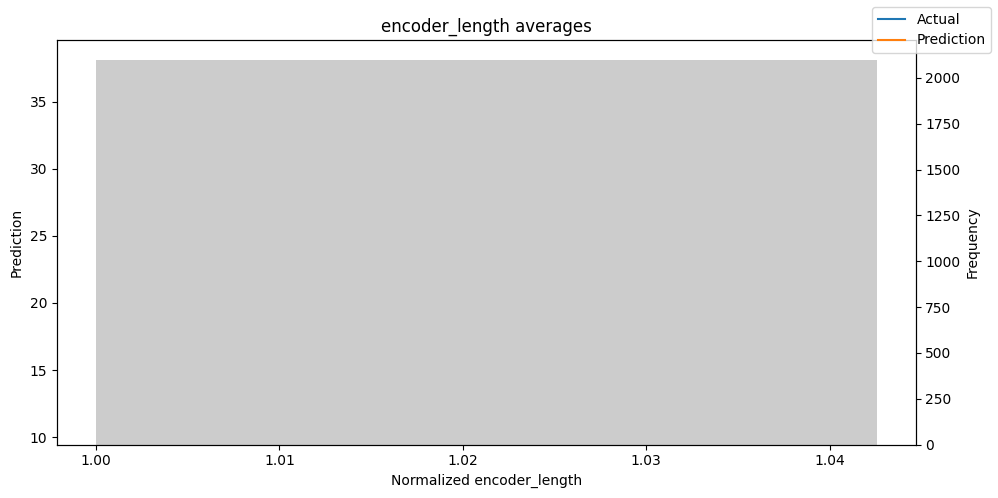

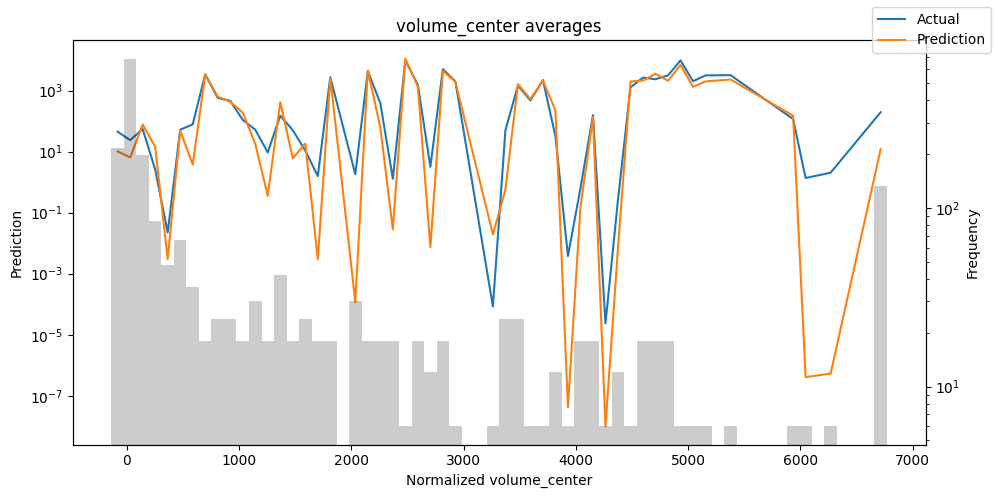

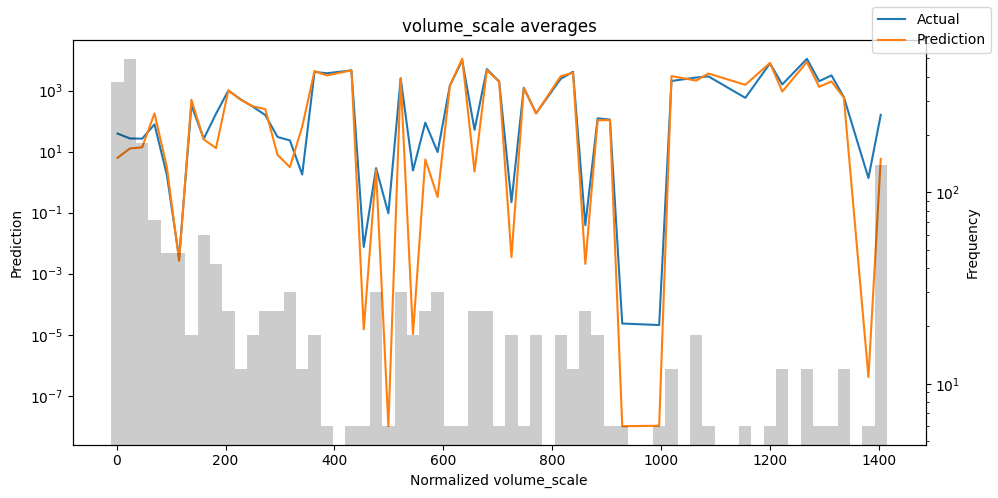

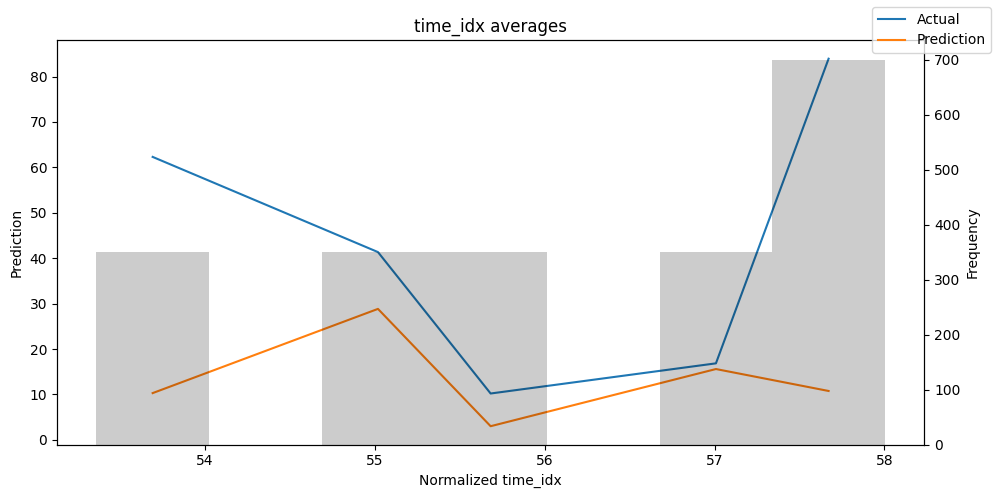

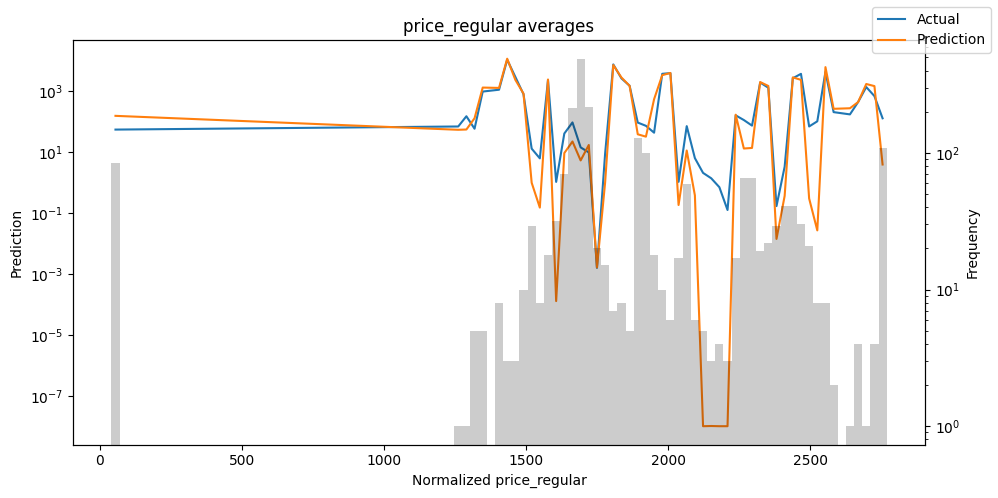

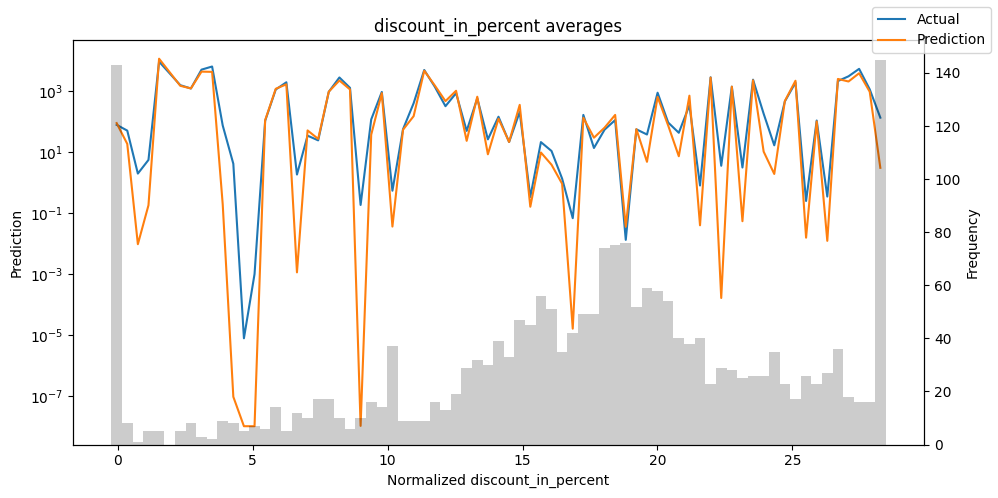

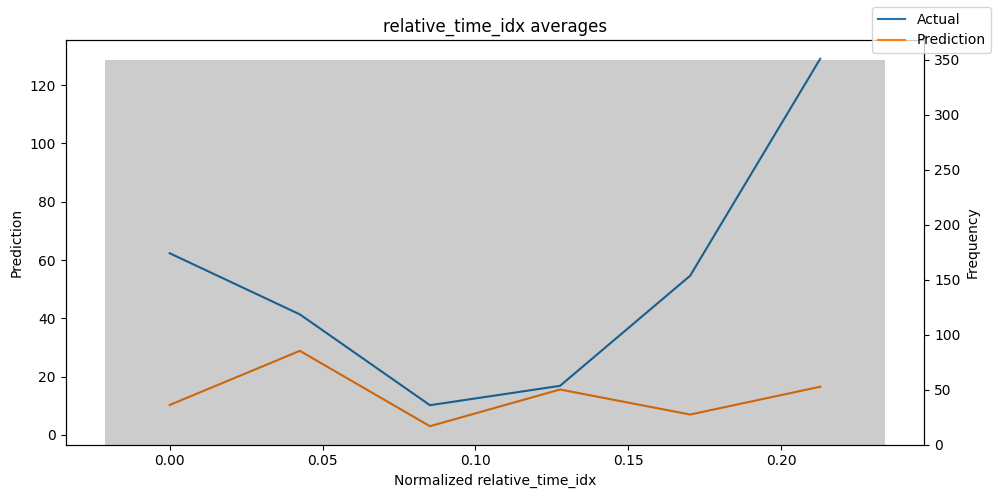

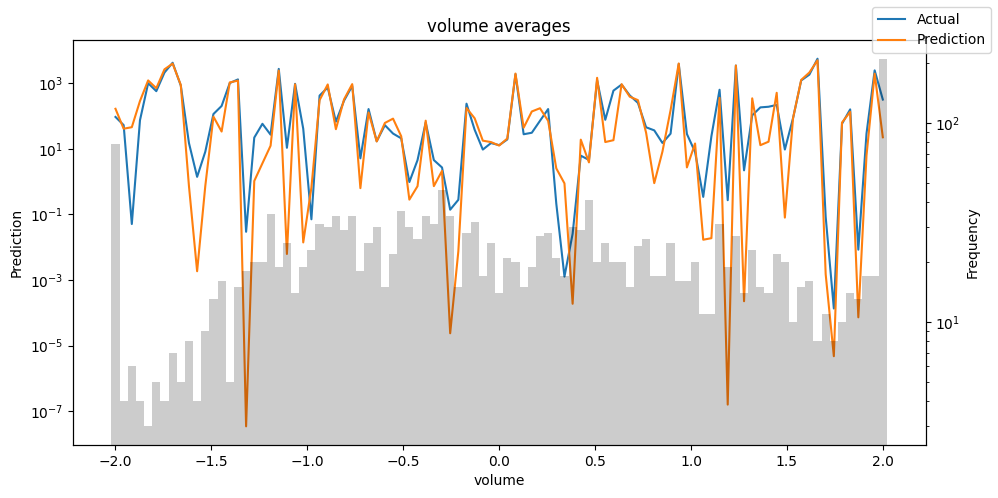

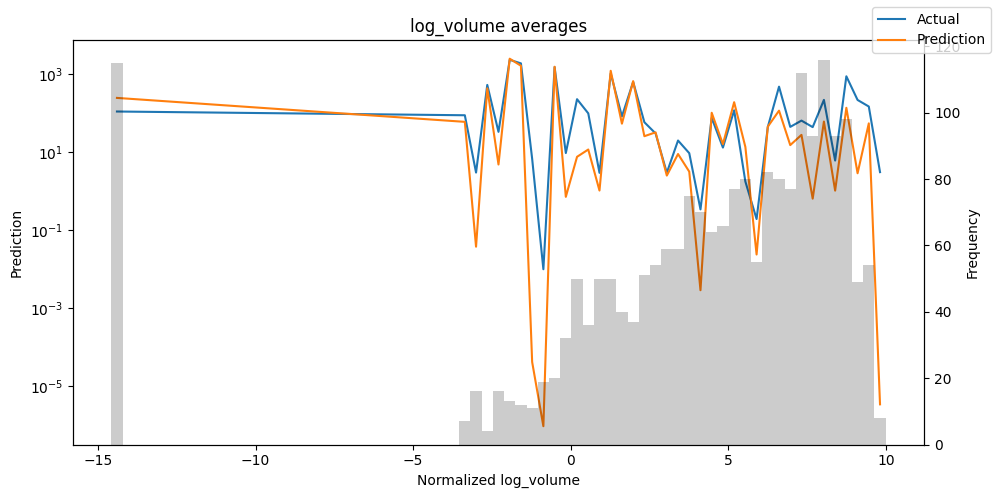

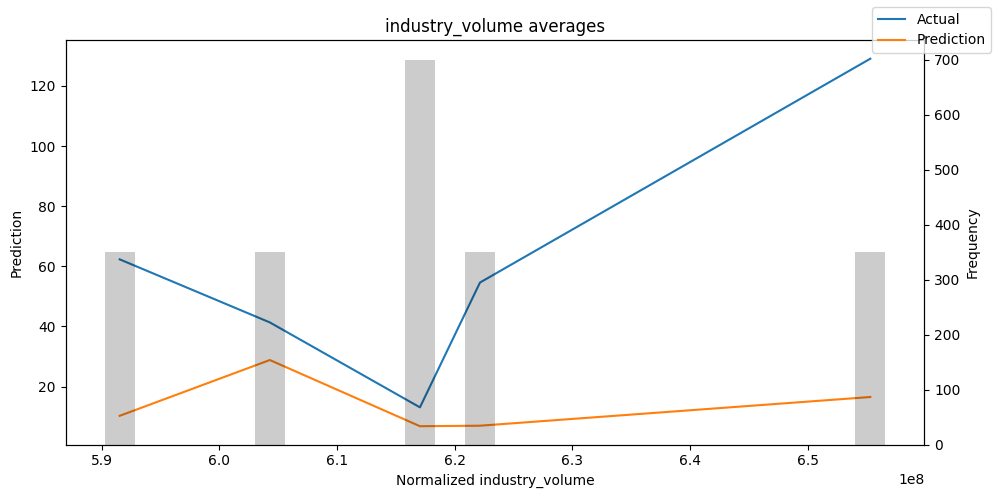

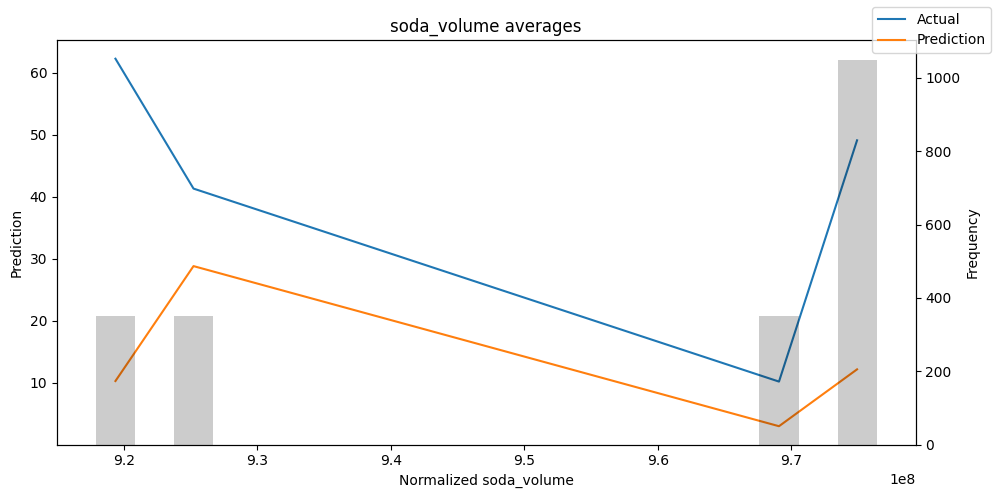

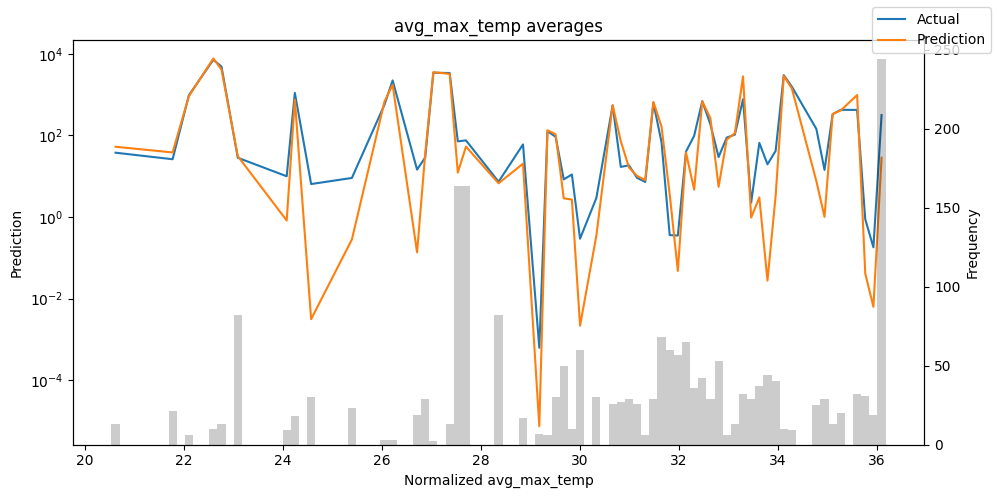

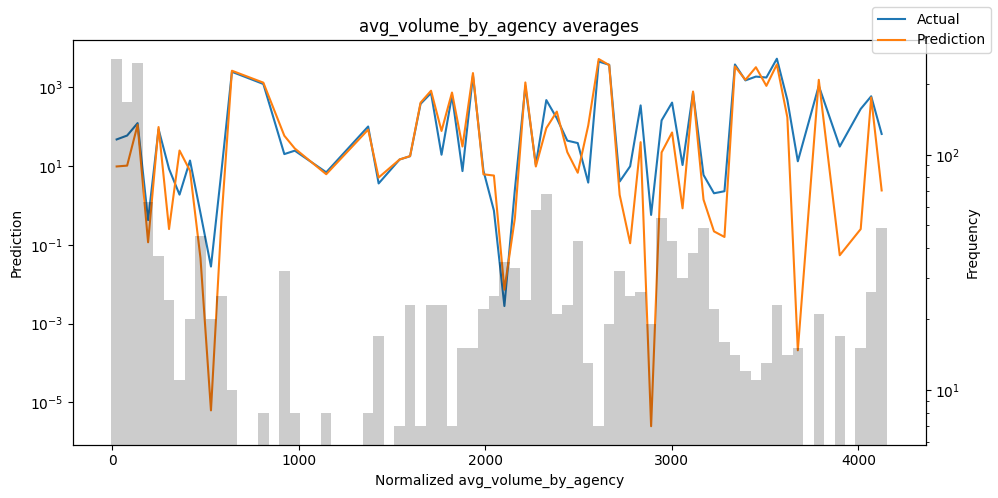

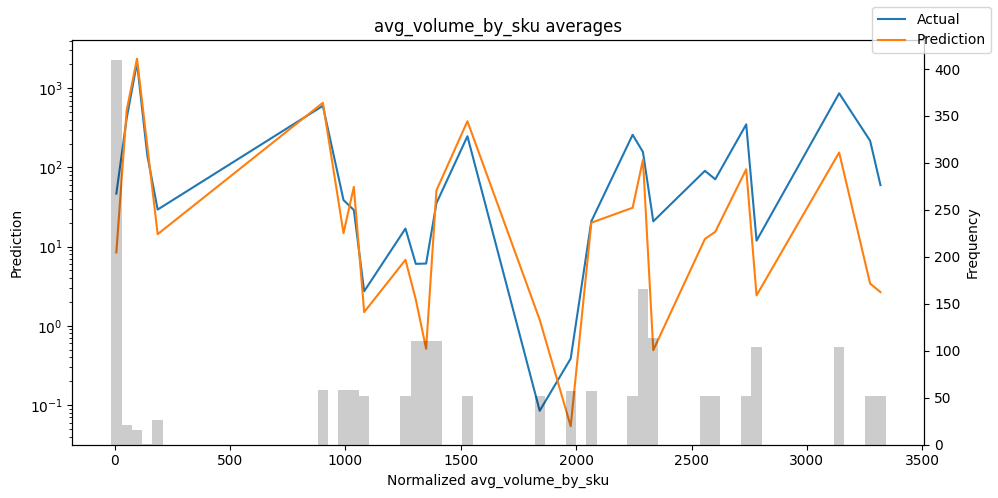

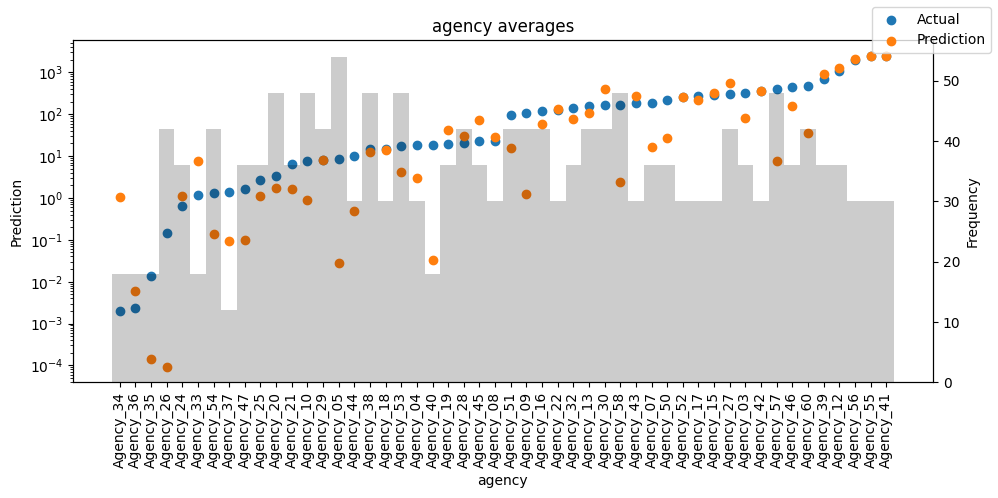

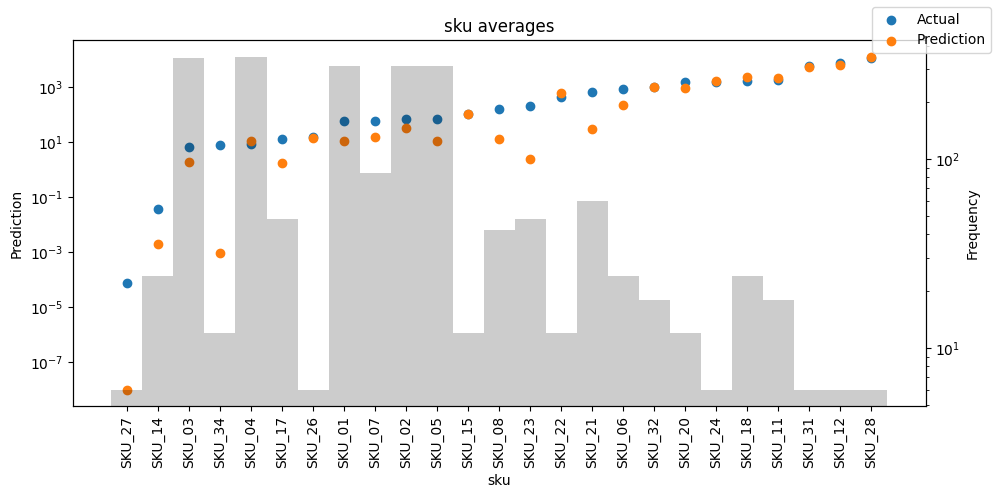

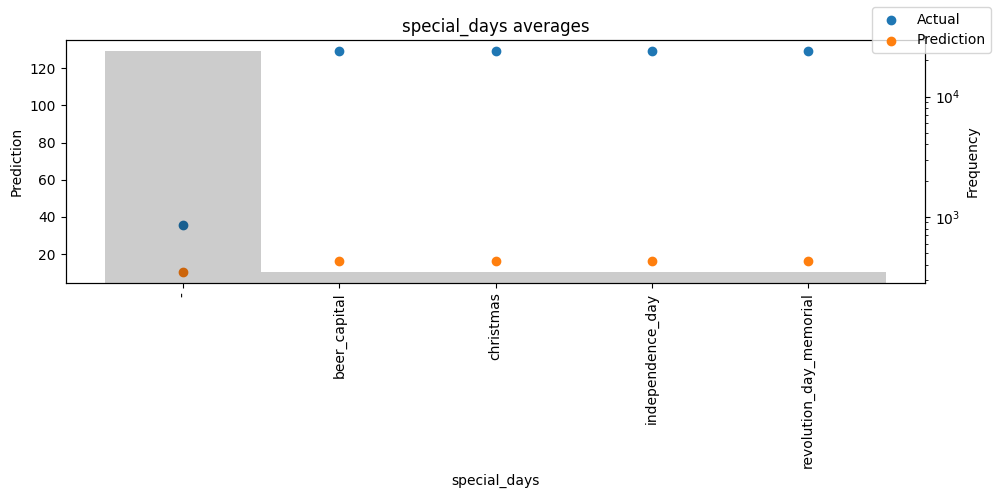

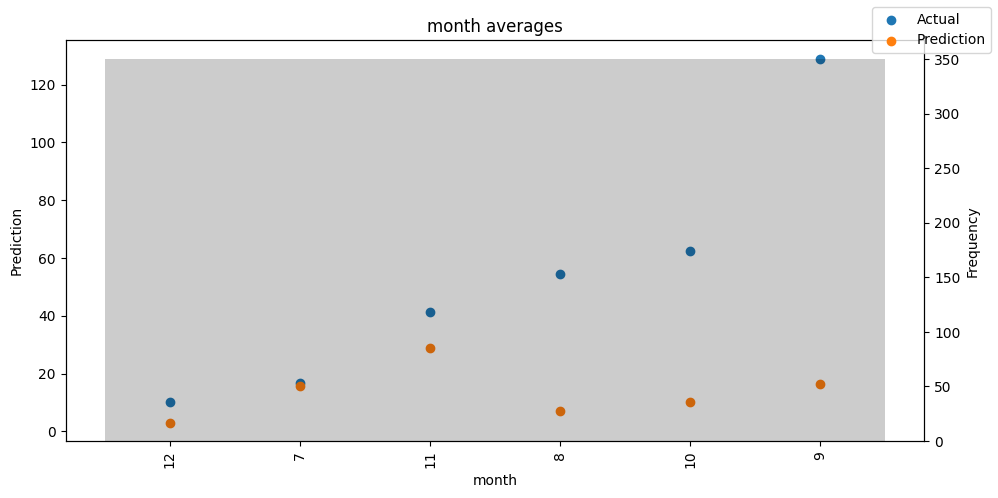

In [29]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [30]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

In [32]:
decoder_data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_01,SKU_01,35.5320,2018-01-01,618073219,919709619,19.403655,1663.797492,1390.112272,273.685220,153733,120207,-,-,-,christmas,-,-,-,-,-,-,-,-,16.449431,249,60,12,3.570434,2716.823019,30.2557
1,Agency_01,SKU_02,17.1720,2018-01-01,618073219,919709619,19.403655,1697.575472,1412.680031,284.895441,153733,120207,-,-,-,christmas,-,-,-,-,-,-,-,-,16.782490,253,60,12,2.843280,2267.730115,30.2557
2,Agency_01,SKU_03,10.9134,2018-01-01,618073219,919709619,19.403655,1640.111950,1443.480950,196.631000,153733,120207,-,-,-,christmas,-,-,-,-,-,-,-,-,11.988877,251,60,12,2.389991,2304.827516,30.2557
3,Agency_01,SKU_04,80.7057,2018-01-01,618073219,919709619,19.403655,2562.440869,2093.641230,468.799639,153733,120207,-,-,-,christmas,-,-,-,-,-,-,-,-,18.295042,250,60,12,4.390809,1408.486009,30.2557
4,Agency_01,SKU_05,15.1443,2018-01-01,618073219,919709619,19.403655,2025.049474,1572.014619,453.034855,153733,120207,-,-,-,christmas,-,-,-,-,-,-,-,-,22.371545,252,60,12,2.717624,1530.930920,30.2557
